## Notebook to do first tests with the Meta Prophet regression model

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from prophet import Prophet
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [27]:
def unfold_weekday_to_interval(df):
    """
    Adjusts the 'interval' column in the DataFrame by adding the number of seconds corresponding to the day of the week.

    This function converts the 'weekday' column to a numerical representation (0 for Monday, 1 for Tuesday, etc.),
    multiplies it by the number of seconds in a day (86400), and adds this value to the 'interval' column. The 'weekday'
    column is then dropped from the DataFrame.

    Parameters:
    df (pandas.DataFrame): A DataFrame containing 'interval' and 'weekday' columns.

    Returns:a
    pandas.DataFrame: The modified DataFrame with the updated 'interval' column and without the 'weekday' column.
    """
    weekday_to_num = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
    seconds_per_day = 86400
    df['interval'] = df.apply(lambda row: row['interval'] + (weekday_to_num[row['weekday']] * seconds_per_day), axis=1)
    df = df.drop(columns=['weekday'])
    return df

In [28]:
train_data = pd.read_csv('') # Insert train data path
train_data = train_data.drop(columns=['day', 'long', 'lat', 'pos', 'length'], axis = 1)
test_data = pd.read_csv('') # Insert test data patht
test_data = test_data.drop(columns=['day', 'long', 'lat', 'pos', 'length'], axis = 1)

In [29]:
save_path = '' # Insert save path for the models

In [30]:
train_data_cp = train_data.copy()
test_data_cp = test_data.copy()
train_data_cp = unfold_weekday_to_interval(train_data_cp)
test_data_cp = unfold_weekday_to_interval(test_data_cp)

In [31]:
train_data_cp

,interval,detid,traffic
0,345600.0,CNTR_N00/005g1,48
1,349200.0,CNTR_N00/005g1,41
2,352800.0,CNTR_N00/005g1,25
3,356400.0,CNTR_N00/005g1,13
4,360000.0,CNTR_N00/005g1,14
...,...,...,...
1664645,590400.0,SOUT_N10/313b1,16
1664646,594000.0,SOUT_N10/313b1,6
1664647,597600.0,SOUT_N10/313b1,4
1664648,601200.0,SOUT_N10/313b1,3


### Encode detids 

In [32]:
label_encoder = LabelEncoder()
train_data_cp['detid'] = label_encoder.fit_transform(train_data_cp['detid'])
test_data_cp['detid'] = label_encoder.fit_transform(test_data_cp['detid'])

In [33]:
train_data_cp

,interval,detid,traffic
0,345600.0,0,48
1,349200.0,0,41
2,352800.0,0,25
3,356400.0,0,13
4,360000.0,0,14
...,...,...,...
1664645,590400.0,3599,16
1664646,594000.0,3599,6
1664647,597600.0,3599,4
1664648,601200.0,3599,3


### Insert datetime objects

In [34]:
monday_midnight = datetime(2015, 5, 18)
train_data_cp['datetime'] = train_data_cp['interval'].apply(lambda x: monday_midnight + timedelta(seconds=x))
test_data_cp['datetime'] = test_data_cp['interval'].apply(lambda x: monday_midnight + timedelta(seconds=x))

In [35]:
train_data_cp

,interval,detid,traffic,datetime
0,345600.0,0,48,2015-05-22 00:00:00
1,349200.0,0,41,2015-05-22 01:00:00
2,352800.0,0,25,2015-05-22 02:00:00
3,356400.0,0,13,2015-05-22 03:00:00
4,360000.0,0,14,2015-05-22 04:00:00
...,...,...,...,...
1664645,590400.0,3599,16,2015-05-24 20:00:00
1664646,594000.0,3599,6,2015-05-24 21:00:00
1664647,597600.0,3599,4,2015-05-24 22:00:00
1664648,601200.0,3599,3,2015-05-24 23:00:00


### Try for one sensor

3048


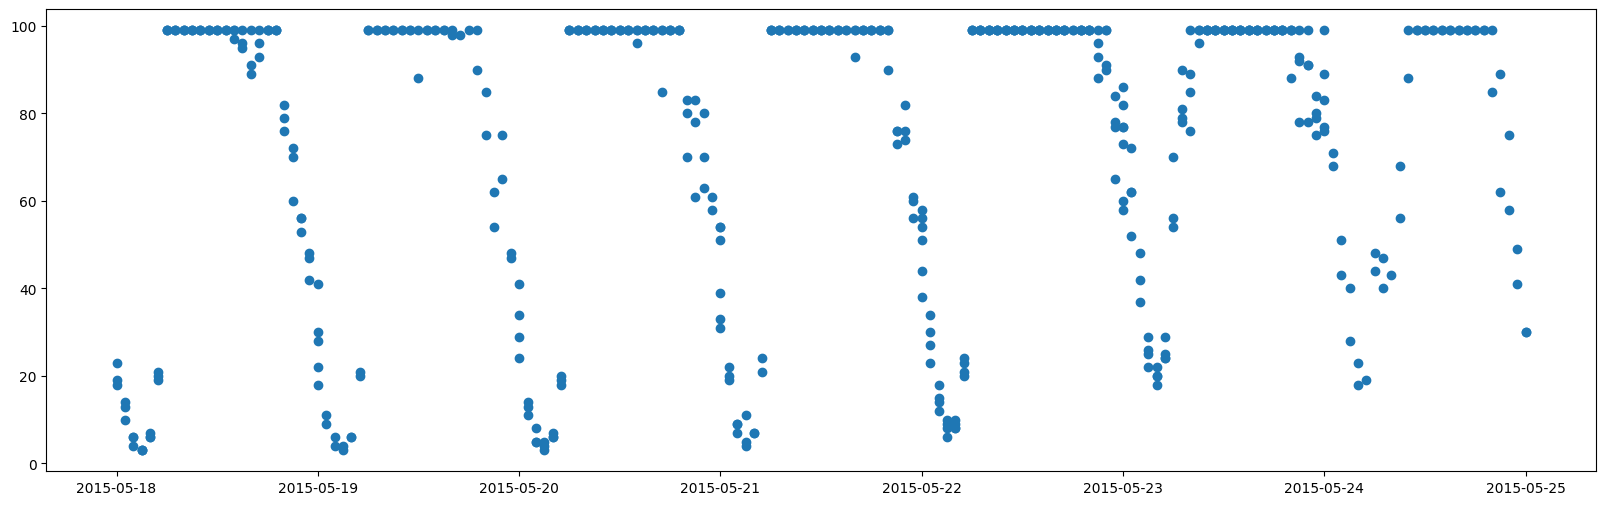

In [36]:
randint = np.random.randint(0,3600)
train_data_cp_randsens = train_data_cp[train_data_cp['detid'] == randint]
plt.figure(figsize=(20,6))
plt.scatter(train_data_cp_randsens.datetime, train_data_cp_randsens.traffic)
print(randint)

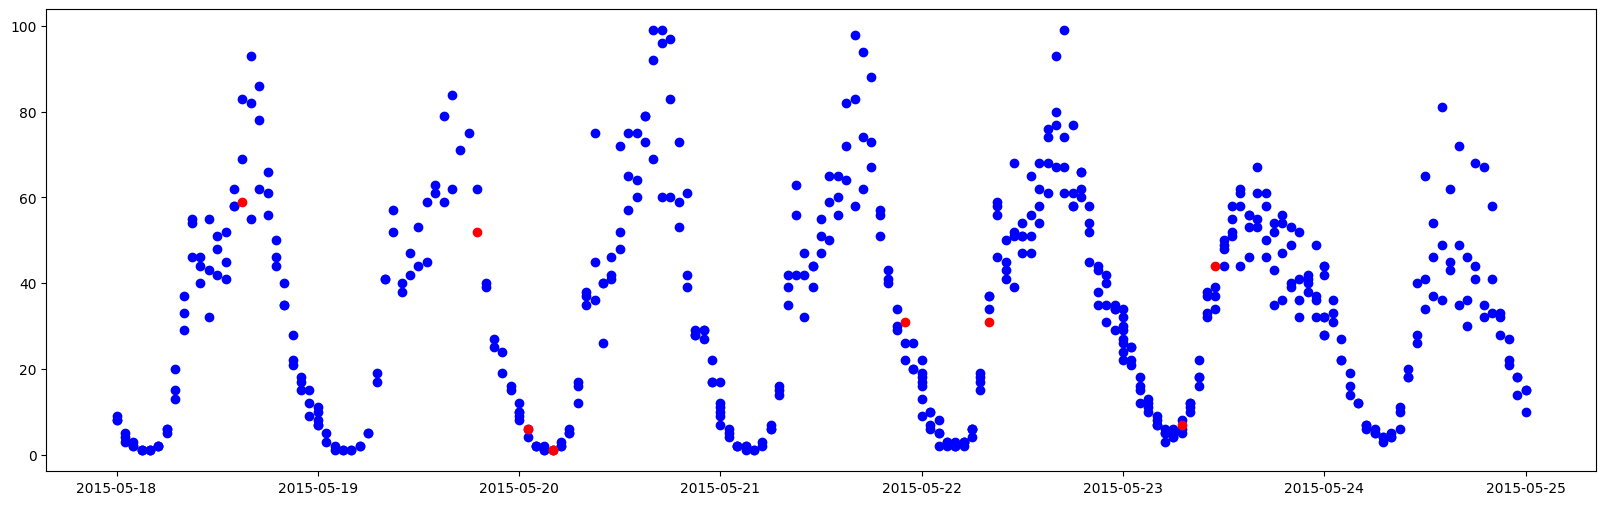

In [37]:
train_data_cp_sensor = train_data_cp[train_data_cp['detid'] == 2086]
test_data_cp_sensor = test_data_cp[test_data_cp['detid'] == 2086]
plt.figure(figsize=(20,6))
plt.scatter(train_data_cp_sensor.datetime, train_data_cp_sensor.traffic, color='blue')
plt.scatter(test_data_cp_sensor.datetime, test_data_cp_sensor.traffic, color='red')

In [38]:
train_data_cp_sensor

,interval,detid,traffic,datetime
47717,345600.0,2086,22,2015-05-22 00:00:00
47718,349200.0,2086,6,2015-05-22 01:00:00
47719,352800.0,2086,2,2015-05-22 02:00:00
47720,356400.0,2086,2,2015-05-22 03:00:00
47721,360000.0,2086,2,2015-05-22 04:00:00
...,...,...,...,...
1631793,590400.0,2086,33,2015-05-24 20:00:00
1631794,594000.0,2086,28,2015-05-24 21:00:00
1631795,597600.0,2086,27,2015-05-24 22:00:00
1631796,601200.0,2086,18,2015-05-24 23:00:00


In [39]:
prophet_data_test = pd.DataFrame()
prophet_data_test['ds'] = train_data_cp_sensor['datetime']
prophet_data_test['y'] = train_data_cp_sensor['traffic']
prophet_data_test

,ds,y
47717,2015-05-22 00:00:00,22
47718,2015-05-22 01:00:00,6
47719,2015-05-22 02:00:00,2
47720,2015-05-22 03:00:00,2
47721,2015-05-22 04:00:00,2
...,...,...
1631793,2015-05-24 20:00:00,33
1631794,2015-05-24 21:00:00,28
1631795,2015-05-24 22:00:00,27
1631796,2015-05-24 23:00:00,18


13:52:46 - cmdstanpy - INFO - Chain [1] start processing
13:52:46 - cmdstanpy - INFO - Chain [1] done processing


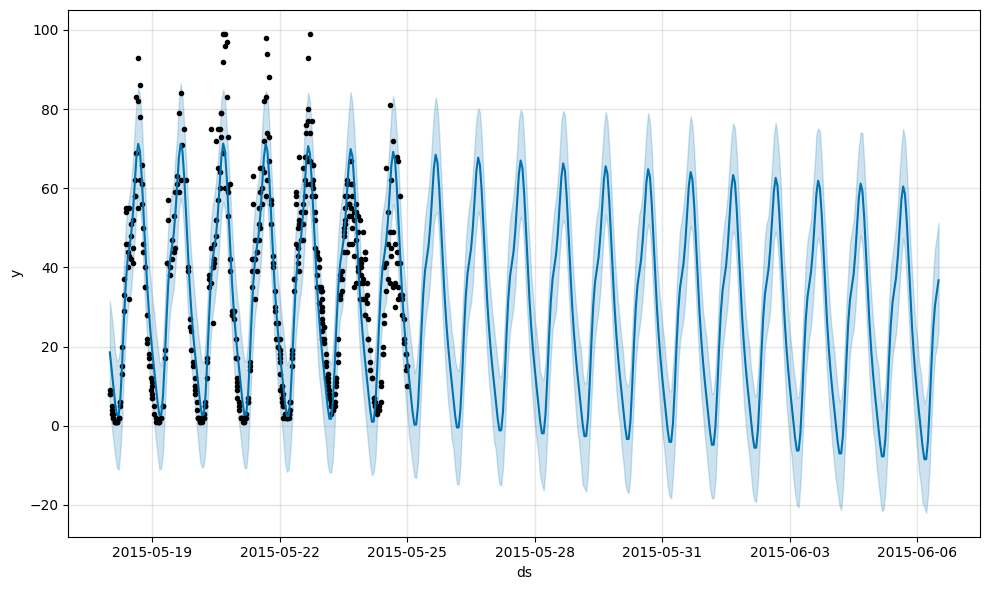

In [40]:
m = Prophet(changepoint_prior_scale=0.01).fit(prophet_data_test)
future = m.make_future_dataframe(periods=300, freq='h')
fcst = m.predict(future)
fig = m.plot(fcst)

### Check performance for one sensor

In [41]:
X_test = pd.DataFrame()
X_test['ds'] = test_data_cp_sensor.datetime
X_test

,ds
10728,2015-05-20 04:00:00
21184,2015-05-23 07:00:00
27961,2015-05-20 01:00:00
30113,2015-05-21 22:00:00
32220,2015-05-18 15:00:00
34280,2015-05-19 19:00:00
36297,2015-05-20 04:00:00
40572,2015-05-22 08:00:00
42652,2015-05-23 11:00:00


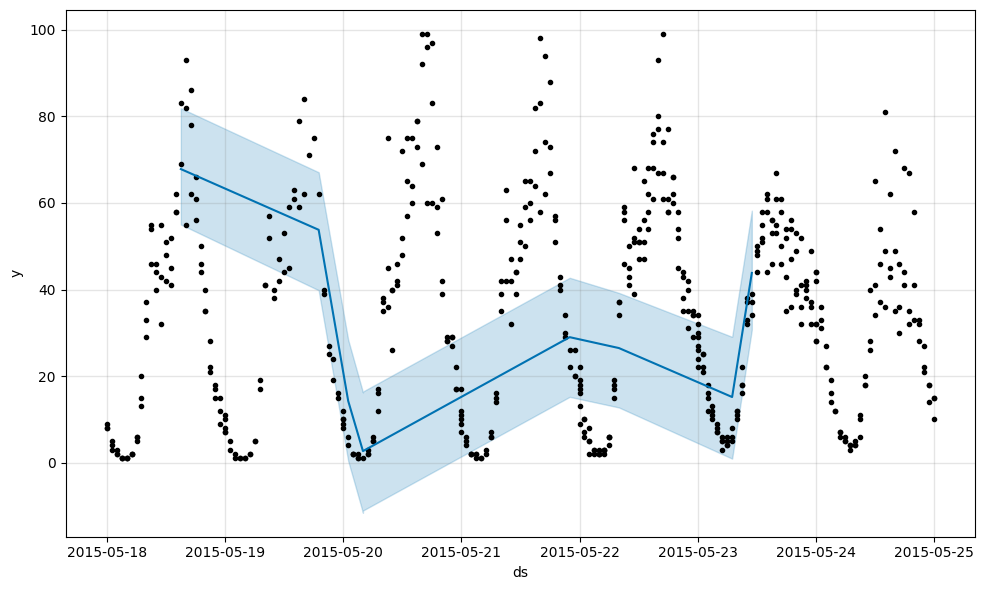

In [42]:
fcst = m.predict(X_test)
fig = m.plot(fcst)

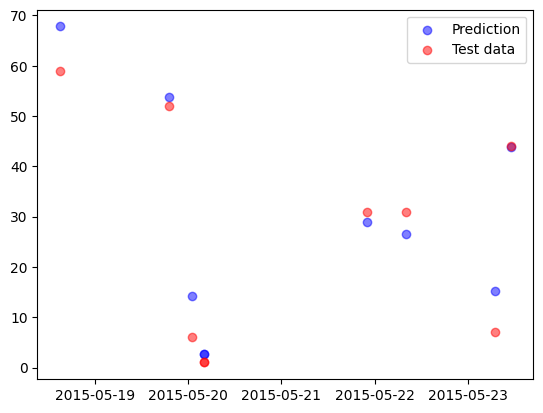

In [43]:
plt.scatter(fcst.ds, fcst.yhat, color='blue', label='Prediction', alpha=.5)
plt.scatter(test_data_cp_sensor['datetime'], test_data_cp_sensor['traffic'], color='red', label='Test data', alpha=.5)
plt.legend()

### Fitting with all encoded sensors

In [44]:
def onehot_encode_categorical(df, column_name):
    encoder = OneHotEncoder(sparse_output=False)
    column_encoded = encoder.fit_transform(df[[column_name]])

    encoded_columns = encoder.get_feature_names_out([column_name])
    column_encoded_df = pd.DataFrame(column_encoded, columns=encoded_columns)

    # Concatenate the one-hot encoded columns back to the original dataset
    df_encoded = pd.concat([df, column_encoded_df], axis=1)

    # Drop the original 'detid' column if no longer needed
    df_encoded.drop(columns=[column_name], inplace=True)

    return df_encoded

In [45]:
def label_encode_categorical(df, column_name):
    df_cp = df.copy()
    label_encoder = LabelEncoder()
    df_cp[column_name] = label_encoder.fit_transform(df_cp[column_name])
    return df_cp 

In [46]:
def interval_to_datetime(df, interval_column_name):
    df_cp = df.copy()
    monday_midnight = datetime(2015, 5, 18)
    df_cp['datetime'] = df_cp[interval_column_name].apply(lambda x: monday_midnight + timedelta(seconds=x))
    df_cp = df_cp.drop(interval_column_name, axis=1)
    return df_cp

In [47]:
train_data2 = train_data.copy()
train_data2_enc = label_encode_categorical(train_data2, 'detid')
train_data2_enc = unfold_weekday_to_interval(train_data2_enc)
train_data2_enc = interval_to_datetime(train_data2_enc, 'interval')
train_data2_enc = train_data2_enc.rename(columns={'traffic' : 'y', 'datetime' : 'ds'})
train_data2_enc

,detid,y,ds
0,0,48,2015-05-22 00:00:00
1,0,41,2015-05-22 01:00:00
2,0,25,2015-05-22 02:00:00
3,0,13,2015-05-22 03:00:00
4,0,14,2015-05-22 04:00:00
...,...,...,...
1664645,3599,16,2015-05-24 20:00:00
1664646,3599,6,2015-05-24 21:00:00
1664647,3599,4,2015-05-24 22:00:00
1664648,3599,3,2015-05-24 23:00:00


In [ ]:
p_model = Prophet(changepoint_prior_scale=0.01)
p_model.add_regressor('detid')
p_model.fit(train_data2_enc[['ds', 'y', 'detid']])